# Project : Study of the curvature of the minimizers found by different optimizers and how it affects generalization

#### This is the main Notebook file that contains all necessary code to plot most of the different figures present in our report; note that, if you plan to run this file using a GPU, you may need one whose RAM is comparable to the one provided by Google Colab. 

# Module loading

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pyhessian
import Optimizers
import random
from Helpers import *
from LeNet import *
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Data load

Data load part; the dataset we use is the MNIST dataset of handrawn digits, where each sample is of shape 1x28x28. We reshape the images so that they are 1x32x32.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torchvision
import torchvision.datasets as datasets
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
if not os.path.isdir('./data/mnist'):
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
else:
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



In [8]:
type(mnist_trainset)

torchvision.datasets.mnist.MNIST

In [9]:
train_data_tmp = [mnist_trainset[i][0] for i in range(len(mnist_trainset))]
tmp = torch.Tensor(len(mnist_trainset),1, 32, 32)
train_data = torch.cat(train_data_tmp, out=tmp)
train_data = train_data.reshape(len(train_data),1,32,32).to(device)

train_target = torch.Tensor([[mnist_trainset[i][1] for i in range(len(mnist_trainset))]]).reshape(-1)
train_target = train_target.long().to(device)

In [10]:
test_data_tmp = [mnist_testset[i][0] for i in range(len(mnist_testset))]
tmp = torch.Tensor(len(mnist_testset),1, 32, 32)
test_data = torch.cat(test_data_tmp, out=tmp)
test_data = test_data.reshape(len(test_data),1,32,32).to(device)

test_target = torch.Tensor([[mnist_testset[i][1] for i in range(len(mnist_testset))]]).reshape(-1)
test_target = test_target.long().to(device)

# Model training

We train the LeNet model for all the optimizers; the model was trained for 150 epochs each time with batches of size 100.

In [11]:
epochs = 150
batch_size = 100

In [12]:
def train(model, train_data, train_target, name, lr = 0.1):
    optimizer = Optimizers.get_optimizer(model, name, lr)    
    loss = nn.CrossEntropyLoss()
    grad_norm = []
    for i in range(epochs):
        for b in range(0,train_data.size(0), batch_size):
            optimizer.zero_grad()
            train_batch_data = train_data[b : b + batch_size]
            train_batch_target = train_target[b : b + batch_size]
            y_hat = model(train_batch_data)
            l = loss(y_hat, train_batch_target)
            if name.lower() == 'adahessian':
                l.backward(create_graph = True)
            else:
                l.backward()
            optimizer.step()
        grad_norm.append(norm_gradient(model))
        if i % 10 == 0:
          print(i)
    return model, grad_norm

In [13]:
def test(model, test_data, test_target):
  nb_errors  = 0
  i = 0
  for b in range(0,test_data.size(0), batch_size):
    with torch.no_grad():
      y_hat = model(test_data[b:b+batch_size])
      _, pr = y_hat.max(1)
      for k in range(batch_size):
        if pr[k] != test_target[k + b]:
          nb_errors += 1
  return (test_data.size(0)-nb_errors)/test_data.size(0)

In [14]:
first_order = ['adam', 'sgd', 'adagrad']
second_order = ['adahessian']
first_order_perf = {}
second_order_perf = {}

In [15]:
# We train the model using the three first order methods, and print the test accuracy after training the model fully
# We also plot the norm of the gradient with respect to all parameters, to check for convergence of the norm value
for first_order_method in first_order:
  print(first_order_method)
  model = LeNet().to(device)
  model, grad_norms = train(model, train_data, train_target,first_order_method) 
  acc = test(model, test_data, test_target)
  first_order_perf[first_order_method] = (acc,model,grad_norms)
  print(acc)
  print("------------------------------------------------------------")

adam
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.9841
------------------------------------------------------------
sgd
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.9903
------------------------------------------------------------
adagrad
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.976
------------------------------------------------------------


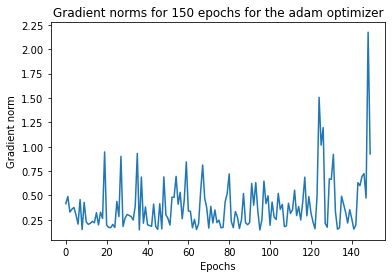

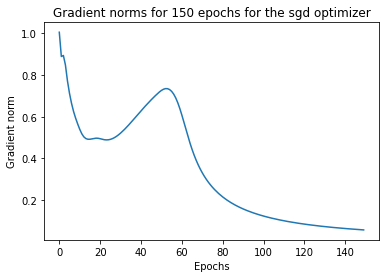

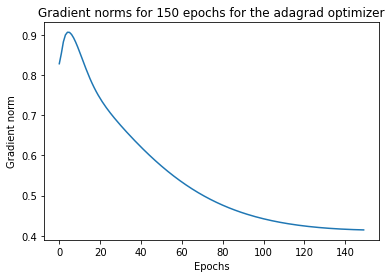

In [16]:
#Plot gradient norm with repect to the epoch for every first order optimizers
for k, value in first_order_perf.items():
  opt_name = k
  grad_norms = value[-1]
  plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

In [17]:
# We train the model using AdaHessian
for second_order_method in second_order:
  print(second_order_method)
  model =LeNet().to(device)
  model, grad_norms = train(model, train_data, train_target,second_order_method)
  acc = test(model, test_data, test_target)
  second_order_perf[second_order_method] = acc,model,grad_norms
  print(acc)  
  print("------------------------------------------------------------")

adahessian


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
0.9889
------------------------------------------------------------


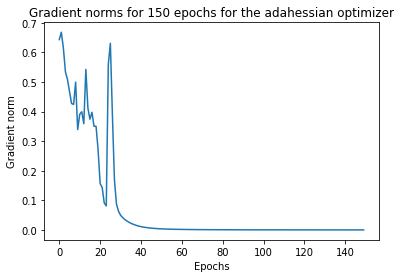

In [18]:
# plotting gradient norm for the model trained with adahessian
for k, value in second_order_perf.items():
  opt_name = k
  grad_norms = value[-1]
  plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

# Eigenvalue densities per optimizer

Plots the eigenvalue densities of the model when trained with different optimizers. To do this, PyHessian needs either a subset or the whole data. We pass the whole dataset each time.

In [19]:
i = 0
model_batch_size = 60_000
inputs, targets = train_data[model_batch_size*i:model_batch_size*(i+1)],train_target[model_batch_size*i:model_batch_size*(i+1)]

/usr/local/lib/python3.7/dist-packages/pyhessian/hessian.py:261: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  a_, b_ = torch.eig(T, eigenvectors=True)


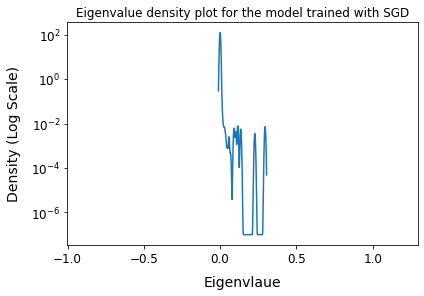

In [20]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with SGD")

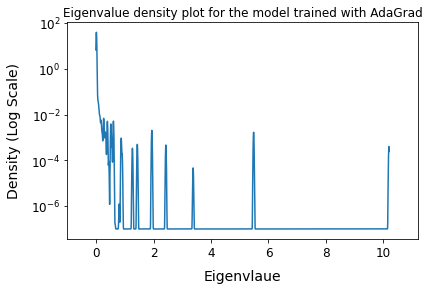

In [21]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with AdaGrad")

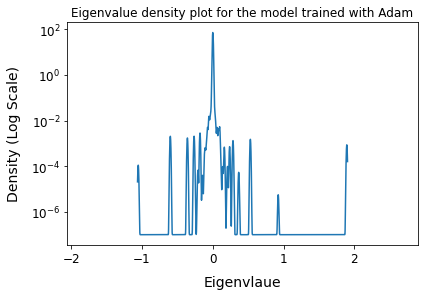

In [22]:
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with Adam")

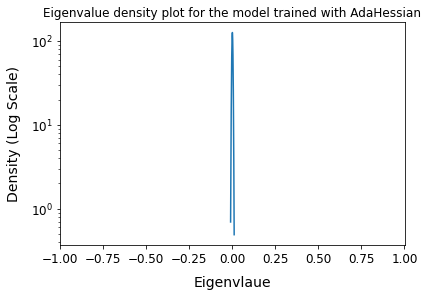

In [23]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with AdaHessian")

# 2D Loss landscapes

Plots the loss landscape for every version of the model; to do so, we disturb the model parameters along the eigenvector corresponding to the largest approximated eigenvalue of the Hessian information computed by PyHessian. We did this to check the sharpness of each solution.

It might be interesting to also try to perturb the model along the gradient's direction if its norm is not 0.

In [24]:
#distrubs the parameters of the model alongside 1 direction
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

In [25]:
#disturbs the parameters of the model alongside 2 direction
def get_params2(model_orig,  model_perb, direction,direction2, alpha,beta):
    for m_orig, m_perb, d ,d2 in zip(model_orig.parameters(), model_perb.parameters(), direction,direction2):
        m_perb.data = m_orig.data + alpha * d+ beta * d2
    return model_perb

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector for the model trained with SGD')

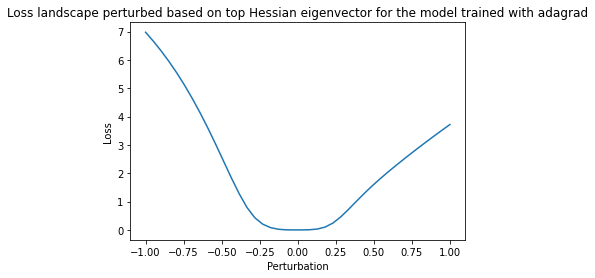

In [26]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with SGD')    

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector for the model trained with adagrad')

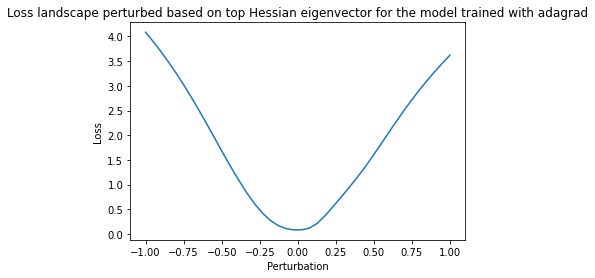

In [27]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adagrad')    

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector for the model trained with adam')

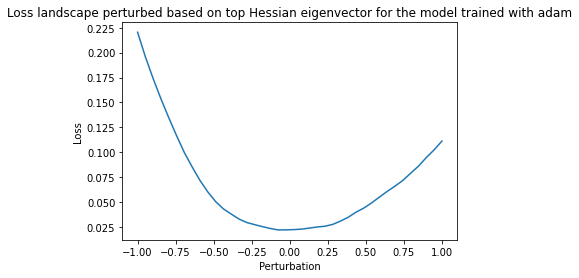

In [28]:
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adam')    

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector for the model trained with adahessian')

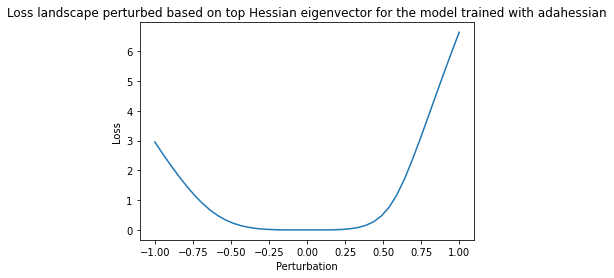

In [29]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adahessian')  

In [30]:
def get_params2(model_orig,  model_perb, direction,direction2, alpha,beta):
    for m_orig, m_perb, d ,d2 in zip(model_orig.parameters(), model_perb.parameters(), direction,direction2):
        m_perb.data = m_orig.data + alpha * d+ beta * d2
    return model_perb

# 3D loss landscapes

In this part, we decided to plot the 3D loss landscape for every trained model in the direction of the 2 top eigenvectors. The reason behind that was to have a better idea of how sharp the solution really than when plotting in 2D.

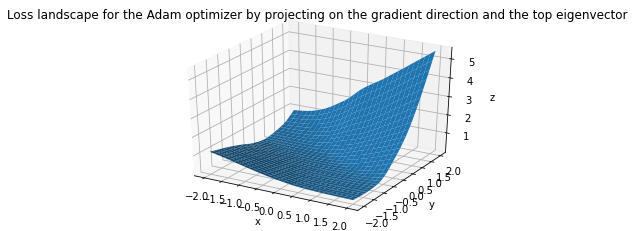

In [31]:
from pyhessian.utils import normalization
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()

model = first_order_perf["adam"][1]
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
precision=30
lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()

model.zero_grad()
loss = criterion(model(inputs), targets)
loss.backward()

v = [p.grad.data for p in model.parameters()]
v = normalization(v)
model.zero_grad()

def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],v, lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
  for j in range(precision):
    Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
plt.title("Loss landscape for the Adam optimizer by projecting on the gradient direction and the top eigenvector")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


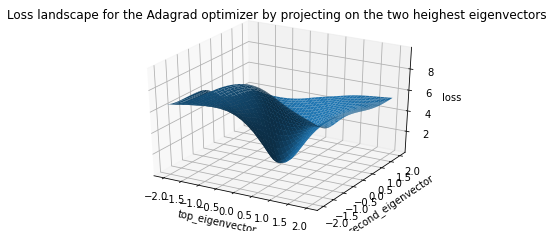

In [32]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
precision=40

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
  for j in range(precision):
    Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
plt.title("Loss landscape for the Adagrad optimizer by projecting on the two heighest eigenvectors")
ax.set_xlabel('top_eigenvector')
ax.set_ylabel('second_eigenvector')
ax.set_zlabel('loss');

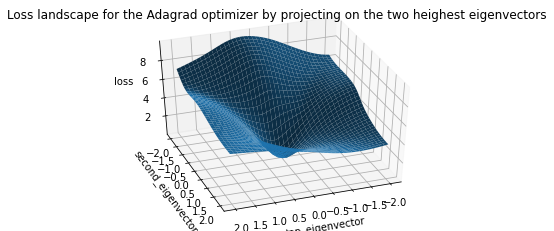

In [33]:
ax.view_init(40, 70)
fig

Text(0.5, 0, 'z')

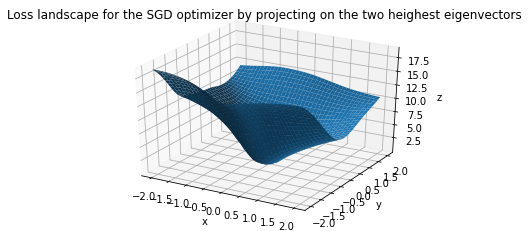

In [34]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
precision=40

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
  for j in range(precision):
    Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
plt.title("Loss landscape for the SGD optimizer by projecting on the two heighest eigenvectors")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

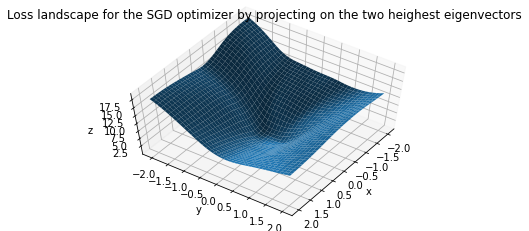

In [35]:
ax.view_init(60, 35)
fig

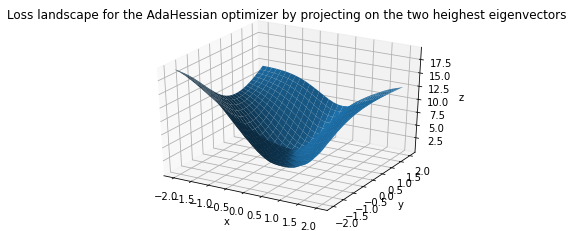

In [36]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
precision=30

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet()
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
  for j in range(precision):
    Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
plt.title("Loss landscape for the AdaHessian optimizer by projecting on the two heighest eigenvectors")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

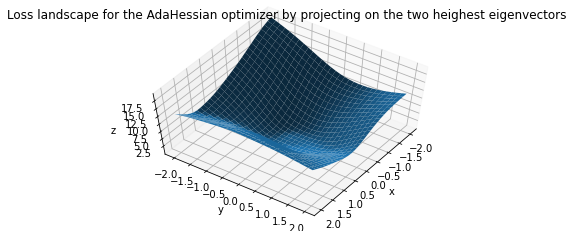

In [37]:
ax.view_init(60, 35)
fig